### Homework Assignment #4
#### Nicholas Kern
#### 9/30/16

In [2]:
from random import uniform
from numpy import logspace, array, arange
from math import sqrt
from time import time,sleep
import multiprocessing as mult
import threading as thread
from ipyparallel import Client
from os import system

In [3]:
def throw(N_darts,verbose=False):
    # Initialize
    N_darts = int(N_darts)
    hit = 0
    
    start = time()
    
    # Loop
    for n in range(N_darts):
        x,y = uniform(0,1), uniform(0,1)
        if sqrt((x-0.5)**2 + (y-0.5)**2) <= 0.5:
            hit += 1
    
    end = time()
    ellapsed = end-start
    rate = float(N_darts) / ellapsed
    
    pi_approx = 4 * float(hit) / N_darts
    
    if verbose == True:
        print "Pi Approx:", pi_approx
        print "N_darts:", N_darts
        print "Execution Time (s):",ellapsed
        print "Darts Thrown / Sec:", rate
    return ellapsed, rate

result = throw(1e4,verbose=True)

Pi Approx: 3.104
N_darts: 10000
Execution Time (s): 0.0623199939728
Darts Thrown / Sec: 160462.146456


In [4]:
dart_range = logspace(3,6,40)

In [6]:
# Multiprocess with Pool
iterate = False
if iterate == True:
    result_pool = array([array(mult.Pool(5).map(throw,dart_range)) for i in range(10)]).T
else:
    result_pool = array(mult.Pool(5).map(throw,dart_range))

In [7]:
# Threading
class container(object):
    def __init__(self):
        pass
    
class map_thread(object):
    def __init__(self,N_threads,thread_data):
        self.C = container()
        self.threads = []
        for i in range(N_threads):
            t = thread.Thread(target=self.worker,args=(thread_data[i],str(i),self.C))
            self.threads.append(t)
            
    def worker(self,data,thread_id,C):
        # Brute Force for each thread
        result = array(map(throw,data))
        C.__dict__['thread_'+thread_id+'_result'] = result
    
    def start(self):
        # Start threads
        for t in self.threads:
            t.start()
            
    def collect_results(self,indices):
        # Wait for finish
        for t in self.threads:
            t.join()
        
        # Compile results
        result = [[] for i in range(indices.size)]
        for i in range(len(indices)):
            for j in range(len(indices[i])):
                result[indices[i][j]] = self.C.__dict__['thread_'+str(i)+'_result'][j]
        
        return array(result)

In [8]:
N_threads = 5
thread_data = array([dart_range[i::5] for i in range(5)])
thread_data_indices = array([arange(len(dart_range))[i::5] for i in range(5)])

In [9]:
M = map_thread(N_threads,thread_data)
M.start()
result_thread = M.collect_results(thread_data_indices)

In [11]:
# Outside of the notebook, you need to start engines
# Do this from a fresh terminal shell via "bash ipcluster_start.sh" in the same directory
# wait for Engines to start, then continue

In [12]:
run throw_darts.py

In [13]:
# ipyparallel
c = Client()
view = c[:]

In [14]:
result_ipy = array(view.map(throw,dart_range).result())

In [15]:
# Plot
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as mp
import scipy.stats as stats

In [2]:
print "2010 MacBook Pro 2.4 GHz Intel Core 2 Duo"

2010 MacBook Pro 2.4 GHz Intel Core 2 Duo


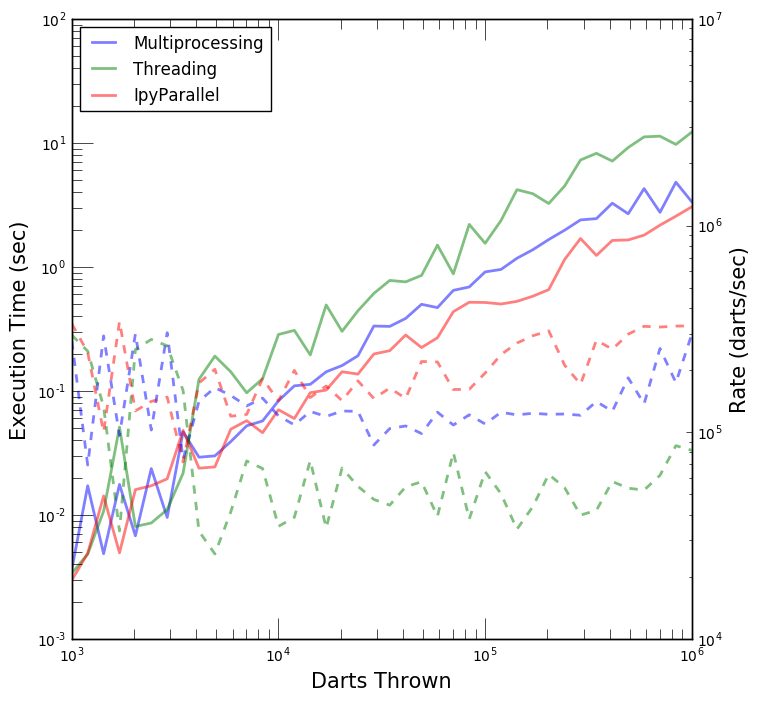

In [18]:
# Plot it!
fig = mp.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.tick_params(which='major',length=15)
ax1.tick_params(which='minor',length=7)
ax1.set_xlabel(r'Darts Thrown',fontsize=15)
ax1.set_ylabel(r'Execution Time (sec)',fontsize=15)
ax2.set_ylabel(r'Rate (darts/sec)',fontsize=15)
ax1.set_ylim(1e-3,1e2)
ax2.set_ylim(1e4,1e7)

p0, = ax1.plot(dart_range,result_pool.T[0],color='b',linewidth=2,alpha=0.5)
p1, = ax1.plot(dart_range,result_thread.T[0],color='g',linewidth=2,alpha=0.5)
p2, = ax1.plot(dart_range,result_ipy.T[0],color='r',linewidth=2,alpha=0.5)

p4, = ax2.plot(dart_range,result_pool.T[1],color='b',linewidth=2,alpha=0.5,linestyle='--')
p5, = ax2.plot(dart_range,result_thread.T[1],color='g',linewidth=2,alpha=0.5,linestyle='--')
p6, = ax2.plot(dart_range,result_ipy.T[1],color='r',linewidth=2,alpha=0.5,linestyle='--')
ax1.legend([p0,p1,p2],['Multiprocessing','Threading','IpyParallel'],loc=2)